# Multi-Instrument Downsampling Dashboard

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))


import importlib, numpy as np
from sys import path
import time, os, copy

from sunpy.map import Map
from sunpy.net import Fido, vso, attrs as a
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection
from astropy import wcs

import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[27,15]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = os.getcwd()

import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_figure
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.instruments.xrt import xrt_wrapper
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper
from EMToolKit.algorithms.sparse_nlmap_dem_wrapper import sparse_nlmap_dem_wrapper

In [2]:
import EMToolKit
import EMToolKit.visualization
importlib.reload(EMToolKit)
importlib.reload(EMToolKit.visualization)
importlib.reload(EMToolKit.visualization.dashboard)
import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_figure
em_collection=0

In [3]:
daystr = '20100725'
date='2010/07/25 17:58:44'
data_path = os.path.join(base_path,'data',daystr)

xl, yl, dx, dy = 240*u.arcsec, -525*u.arcsec, 270*u.arcsec, 240*u.arcsec
#xl, yl, dx, dy = 240*u.arcsec, -525*u.arcsec, 135*u.arcsec, 120*u.arcsec

# Commands for initial data download. Comment out once that's successful.
# VSO can sometimes be a bit flakey here, in my experience, may require multiple tries:
#paths = []
#passbands = np.array([94,131,171,193,211,335])*u.angstrom
#for band in passbands:
#    qry = Fido.search(a.Time(TimeRange(date,12*u.s)),a.Instrument('AIA'),a.Wavelength(band))[0,0]
#    paths.append(Fido.fetch(qry,path=data_path))

aia94dat_path = os.path.join(data_path,'aia_lev1_94a_2010_07_25t17_58_44_13z_image_lev1.fits')
aia131dat_path = os.path.join(data_path,'aia_lev1_131a_2010_07_25t17_58_45_62z_image_lev1.fits')
aia171dat_path = os.path.join(data_path,'aia_lev1_171a_2010_07_25t17_58_36_34z_image_lev1.fits')
aia193dat_path = os.path.join(data_path,'aia_lev1_193a_2010_07_25t17_58_43_84z_image_lev1.fits')
aia211dat_path = os.path.join(data_path,'aia_lev1_211a_2010_07_25t17_58_36_62z_image_lev1.fits')
aia335dat_path = os.path.join(data_path,'aia_lev1_335a_2010_07_25t17_58_39_63z_image_lev1.fits')

# Hinode data was downloaded directly rather than using Fido since I had trouble getting it the latter way:
hinode_path = os.path.join(data_path,'XRT20100725_175844.2.fits')

paths = [aia94dat_path, aia131dat_path, aia171dat_path, aia193dat_path, aia211dat_path, aia335dat_path, hinode_path]
channel_names = np.array(['AIA94_THIN', 'AIA131_THIN', 'AIA171_THIN', 'AIA193_THIN', 'AIA211_THIN', 'AIA335_THIN', 'XRT'])

In [4]:
aiamaps = load_from_paths(paths[0:6],xl=xl,yl=yl,dx=dx,dy=dy)
# We're loading these separately so that we can apply an offset to the XRT data -- there appears
# to be a significant misalignment based on manual inspection and testing:
#xrt_offsets = [-2*u.arcsec, -11*u.arcsec]
#xrt_offsets = [-7*u.arcsec, -23*u.arcsec]
xrt_offsets = [-5*u.arcsec, -20*u.arcsec]
xrtmap = load_from_paths([[paths[0]],hinode_path],xl=xl+xrt_offsets[0],yl=yl+xrt_offsets[1],dx=dx,dy=dy)[1]
xrtmap.meta['crval1'] -= xrt_offsets[0].value
xrtmap.meta['crval2'] -= xrt_offsets[1].value

[xrtmaps,xrterrs,xrt_trlogts,xrt_tresps] = xrt_wrapper([xrtmap])
[maps,errs,trlogts,tresps] = aia_wrapper(aiamaps)
maps.append(xrtmaps[0])
errs.append(xrterrs[0])
trlogts.append(xrt_trlogts[0])
tresps.append(xrt_tresps[0])

logt = np.linspace(5.5,7.5,41)
for i in range(0,len(tresps)):
	tresps[i] = np.interp(logt,trlogts[i],tresps[i])
	trlogts[i] = copy.deepcopy(logt)

# Normalizing the response functions makes them much easier for the solver to handle.
datmax_nominal = 1.0e4 # The nominal maximum of the data
overall_norm = datmax_nominal/np.max(np.array(tresps))
norms = np.max(np.array(tresps),axis=0)/np.max(np.array(tresps))/overall_norm

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs
 [sunpy.map.mapbase]


In [5]:
# Make data sequence from AIA data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA data:
em_collection = emtk.em_collection(datasequence)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs
 [sunpy.map.mapbase]


[Text(0.5, 1.0, 'AIA 94 Temperature Response'),
 Text(0.5, 0, 'Temperature (dB Kelvin)'),
 Text(0, 0.5, 'Response (DN/s/(cm$^{-3})^2$/Mm)')]

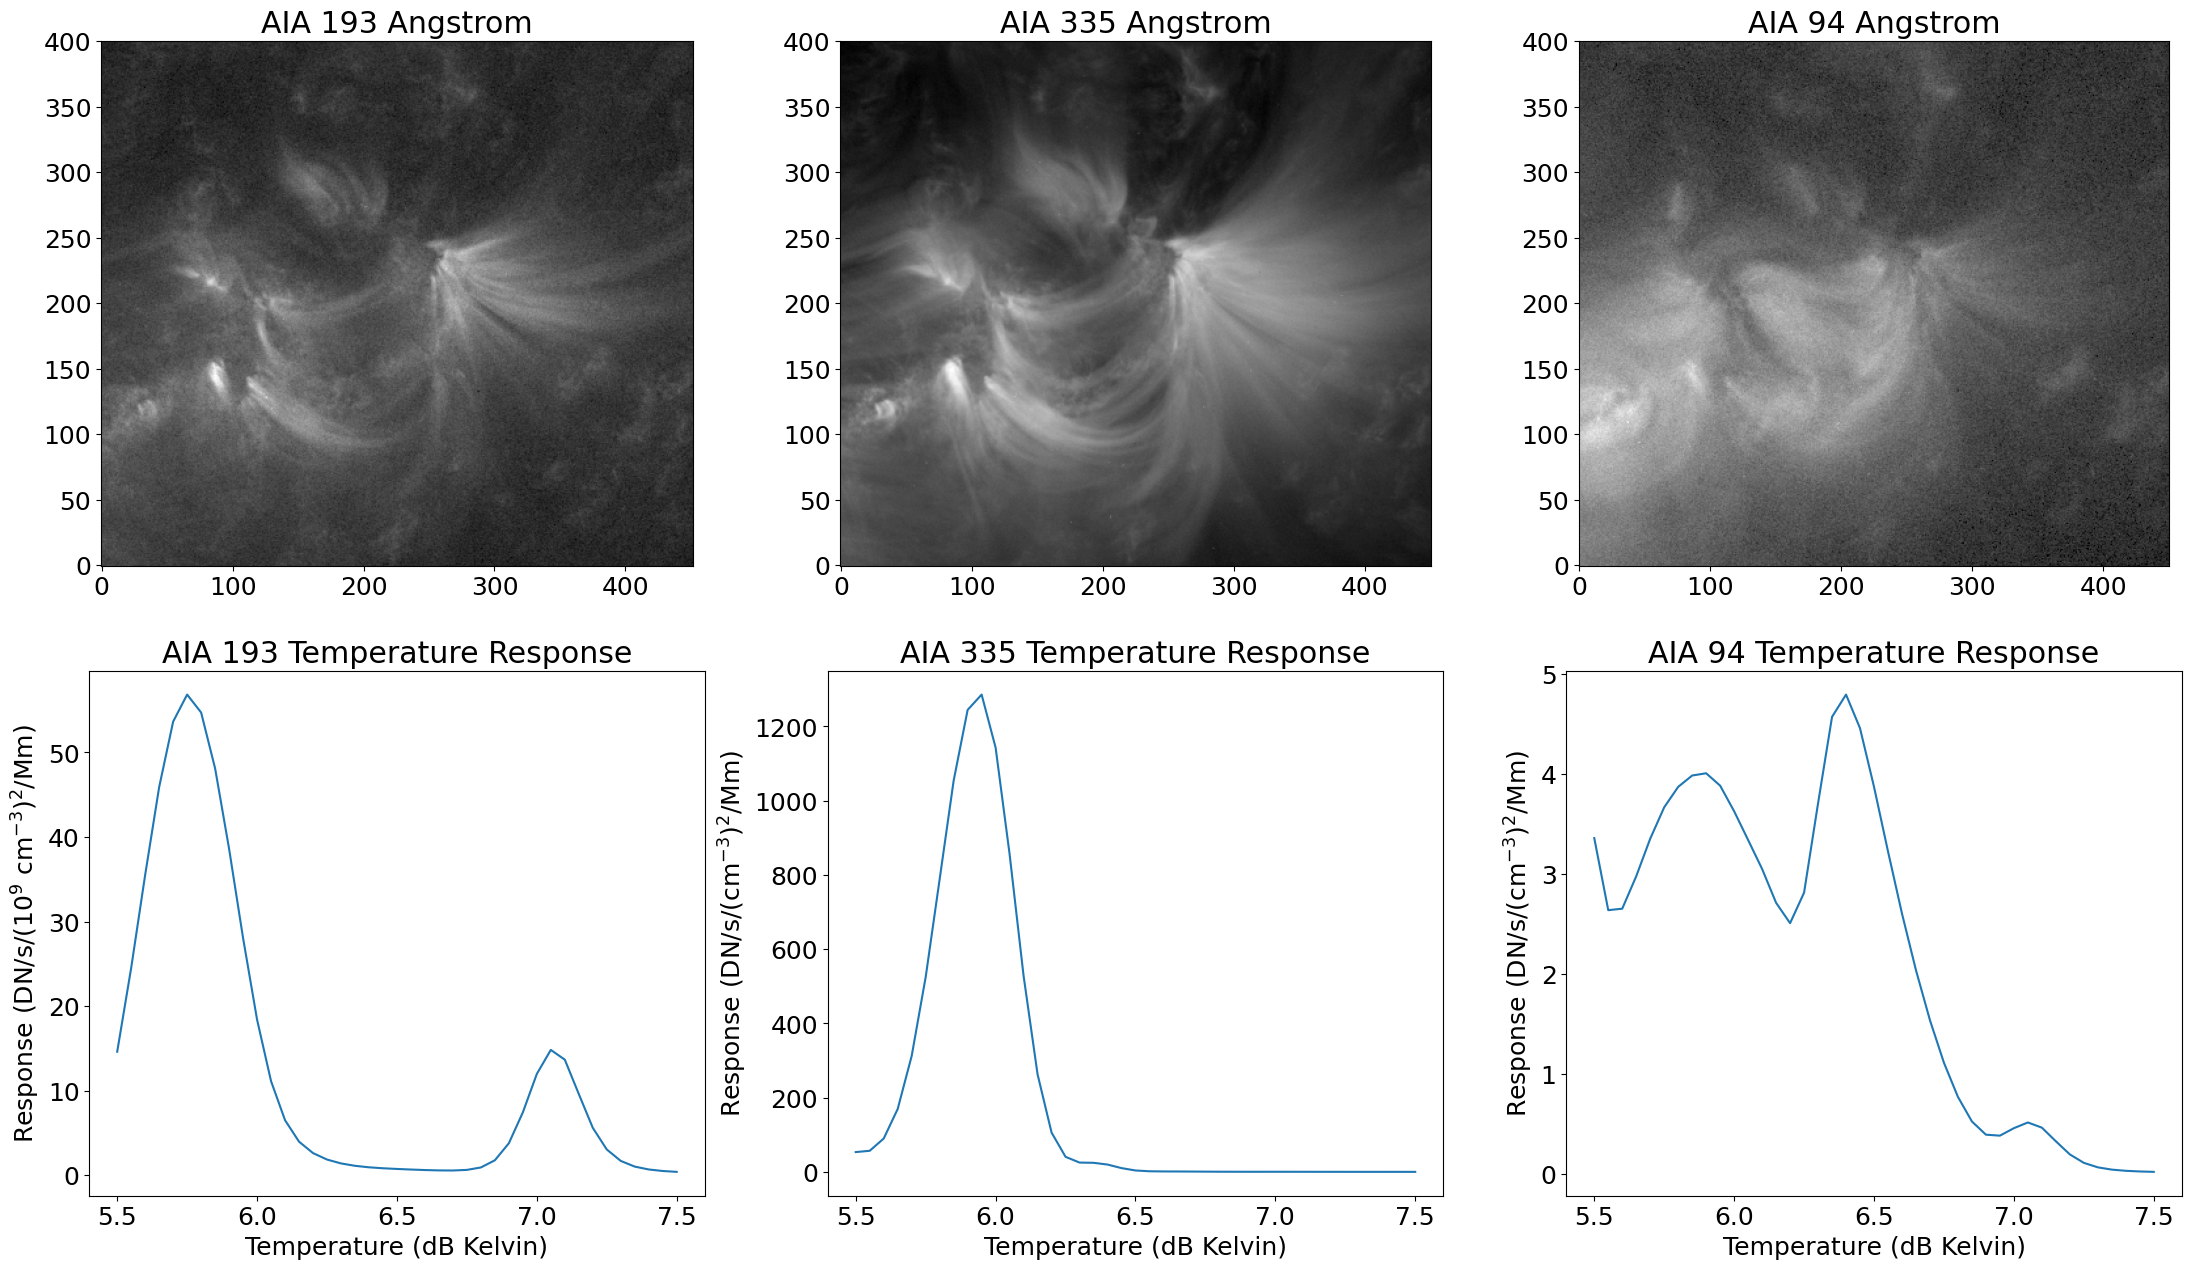

In [6]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,0].set(title='AIA 193 Angstrom')
axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,1].set(title='AIA 335 Angstrom')
axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,2].set(title='AIA 94 Angstrom')
axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
axs[1,2].set(title='AIA 94 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

In [7]:
multi_coeffs, multi_logts, multi_bases, multi_coords, multi_algorithm, multi_em_wrapper = sparse_nlmap_dem_wrapper(datasequence, wrapargs={'norms':norms, 'overall_norm':overall_norm})

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


4.999250215886115 % done after 3.110848903656006 seconds
9.999017524264564 % done after 6.480065822601318 seconds
14.998784832643015 % done after 9.653247594833374 seconds
19.998552141021463 % done after 13.153360843658447 seconds
24.998319449399915 % done after 16.924364805221558 seconds
29.998086757778363 % done after 20.763426065444946 seconds
34.99785406615681 % done after 25.038889169692993 seconds
39.997621374535264 % done after 28.81321120262146 seconds
44.997388682913716 % done after 32.9749596118927 seconds
49.99715599129216 % done after 36.952210903167725 seconds
54.99692329967061 % done after 40.60025453567505 seconds
59.996690608049065 % done after 44.56484603881836 seconds
64.99645791642752 % done after 48.55983114242554 seconds
69.99622522480595 % done after 52.280149936676025 seconds
74.9959925331844 % done after 56.31605935096741 seconds
79.99575984156286 % done after 60.15965175628662 seconds
84.99552714994131 % done after 65.0708065032959 seconds
89.99529445831976 % d

In [8]:
multi_em_demsequence = emtk.dem_model(multi_coeffs, multi_logts, multi_bases, multi_coords, multi_algorithm, multi_em_wrapper)
em_collection.add_model(multi_em_demsequence)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [9]:
multi_synthmaps = [em_collection.synthesize_map(map) for map in em_collection.data()]
multi_synthdata = [map for map in multi_synthmaps]

In [10]:
def calc_resids(synthdata, em_collection):# Calculate the residuals and Chi squared:
	ndata = len(synthdata)
	resids = []
	datasequence = em_collection.data()
	chi2 = 0
	[nx,ny] = datasequence[0].data.shape
	for seq in datasequence: [nx,ny] = [np.min([seq.data.shape[0],nx]),np.min([seq.data.shape[1],ny])]
	for i in range(0,ndata):
		resids.append(((synthdata[i].data-datasequence[i].data)/datasequence[i].uncertainty.array)**2)
		chi2 += np.mean(resids[i])/ndata
	return resids, chi2

#spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
#simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
multi_resids, multi_chi2 = calc_resids(multi_synthdata,em_collection)
print("Multi-instrument Chi squared = ",multi_chi2)
#print('simple_reg_dem Chi squared = ',simpl_chi2, 'spars_em Chi squared = ',spars_chi2)

Multi-instrument Chi squared =  1.0187591209873754


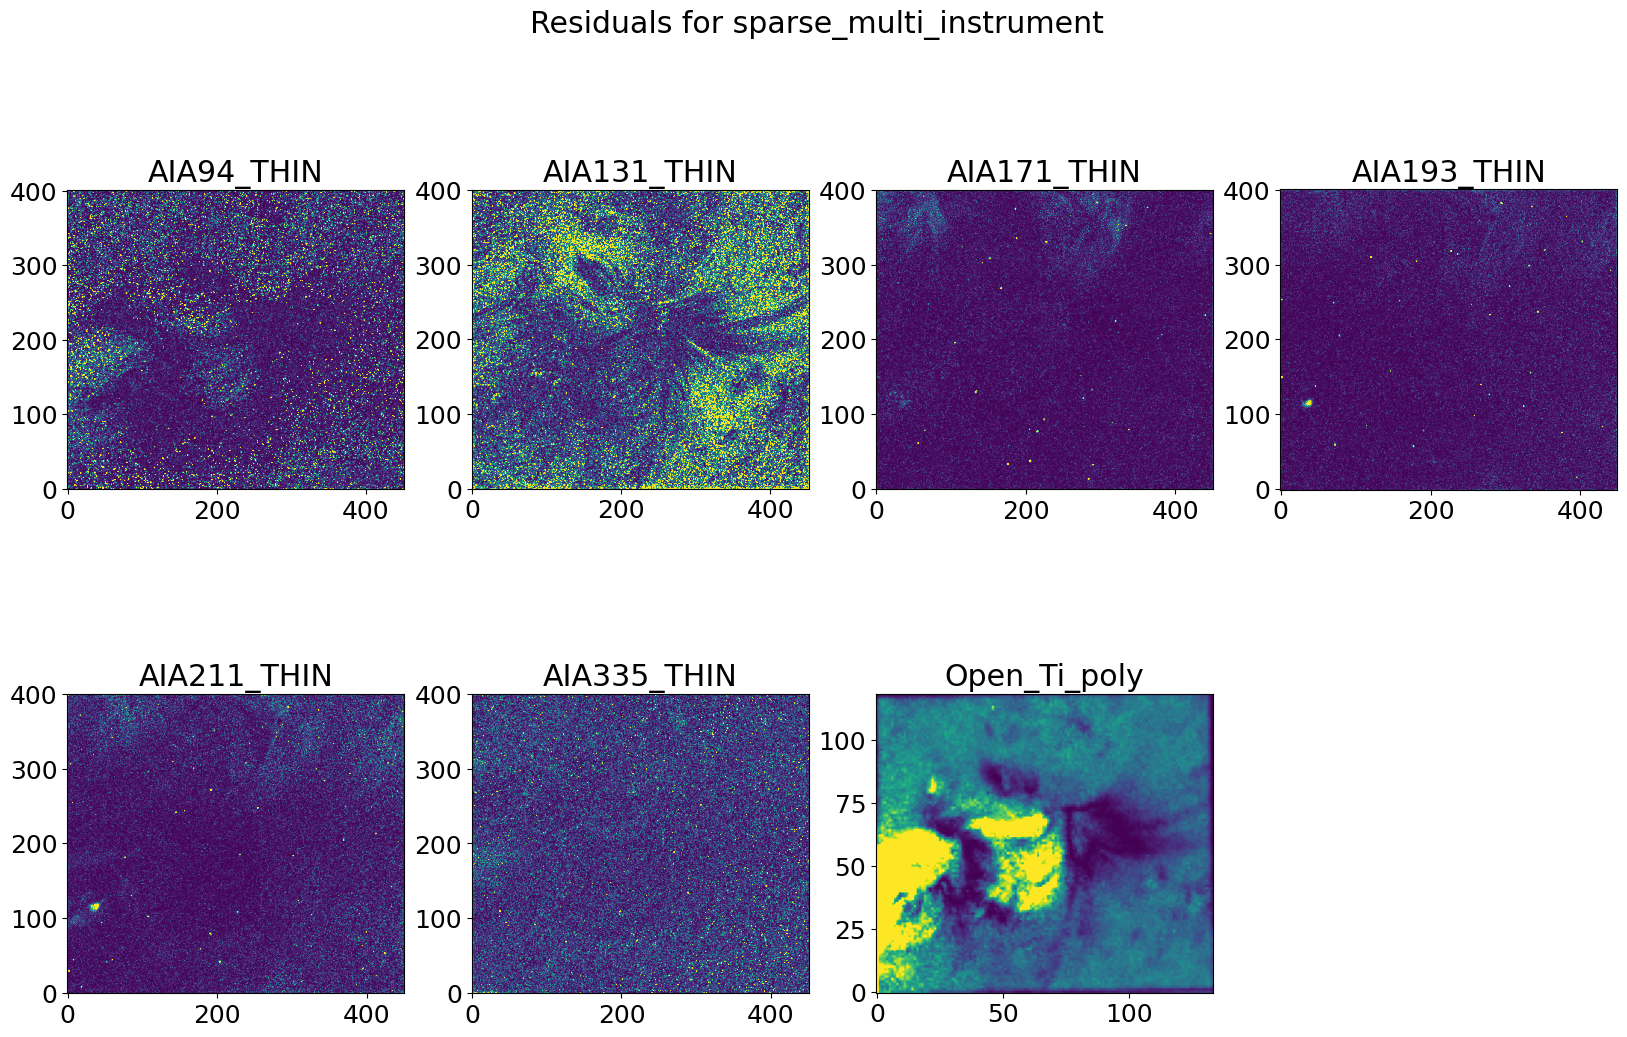

In [11]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+multi_algorithm)
for i in range(0,7):
    ax1 = fig.add_subplot(2,4,i+1)
    ax1.imshow(multi_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

In [12]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


class dashboard_object(object):
    def __init__(self,em_collection):
        self.emc = em_collection

    def widgwrap(self, xpt, ypt, rtemp, gtemp, btemp, sigma, algorithm):
        dashboard_figure(self.emc, plotpoint=[xpt,ypt], temperatures=[rtemp,gtemp,btemp], sigmas=sigma, algorithm=algorithm)

In [13]:
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_figure
dash = dashboard_object(em_collection)

In [14]:
[nx,ny] = dash.emc.collection[dash.emc.collection['models'][0]][0].data.shape
xpt=widgets.IntSlider(min=0, max=nx, value=10, step=1, description='xpt', continuous_update=False)
ypt=widgets.IntSlider(min=0, max=ny, value=100, step=1, description='ypt', continuous_update=False)
rtemp=widgets.FloatSlider(min=5, max=7, value=5.8, step=0.05, description='rtemp', continuous_update=False)
gtemp=widgets.FloatSlider(min=5, max=7, value=6.1, step=0.05, description='gtemp', continuous_update=False)
btemp=widgets.FloatSlider(min=5, max=7, value=6.4, step=0.05, description='btemp', continuous_update=False)
sigma=widgets.FloatSlider(min=0.025, max=0.5, value=0.125, step=0.01, description='sigma', continuous_update=False)
algorithm=widgets.Dropdown(options=dash.emc.collection['models'], description='algorithm', continuous_update=False)
ui = widgets.HBox([xpt,ypt,rtemp,gtemp,btemp,sigma,algorithm])
out = widgets.interactive_output(dash.widgwrap, {'xpt':xpt,'ypt':ypt,'rtemp':rtemp,'gtemp':gtemp,'btemp':btemp,'sigma':sigma,'algorithm':algorithm})
display(ui,out)

Output()